# Loading of Data and Libraries

## Importing Libraries and Packages

In [0]:
import pandas as pd
import string
import numpy as np
import tensorflow as tf
import time
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re

nltk.download('stopwords')
from nltk.corpus import stopwords

from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, GlobalAveragePooling1D, MaxPooling1D, Input, Dense, BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from tensorflow.keras import datasets, layers, models

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


## Loading data

In [0]:
kaggle_data = pd.read_csv('/content/drive/My Drive/BT4222/kaggle_labeled.csv')
crawled_tweets = pd.read_csv('/content/drive/My Drive/BT4222/cust_tweets.csv')

# Pre-processing the data

In [0]:
kaggle_data

In [0]:
crawled_tweets.shape

(7643, 7)

In [0]:
crawled_tweets = crawled_tweets.drop(['Unnamed: 0'], axis = 1)
crawled_tweets = crawled_tweets.rename(columns={"authod_id": 'author_id'})

Check for NaN values 

In [0]:
start_time = time.time()

clean_kaggle = kaggle_data.dropna(thresh=2)
clean_tweets = crawled_tweets.dropna(thresh=2)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.22181344032287598 seconds ---


In [0]:
print(clean_kaggle.shape)
print(clean_tweets.shape)

(590504, 9)
(7643, 7)


Remove links from Text

In [0]:
def remove_links(text):
  text = re.sub(r"http\S+", "", text)
  return text

In [0]:
start_time = time.time()

clean_kaggle['text'] = clean_kaggle.text.apply(str)
clean_tweets['text'] = clean_tweets.text.apply(str)

clean_kaggle['CleanedText'] = clean_kaggle.text.apply(remove_links)
clean_tweets['CleanedText'] = clean_tweets.text.apply(remove_links)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.439281702041626 seconds ---


Remove twitter account handles from CleanedText

In [0]:
def remove_username(text):
  #text = re.sub(r'@[A-Za-z0-9]+','', text)
  text = re.sub(r"(?:\@|https?\://)\S+", '', text)
  return text


In [0]:
start_time = time.time()

clean_kaggle['CleanedText'] = clean_kaggle.CleanedText.apply(remove_username)
clean_tweets['CleanedText'] = clean_tweets.CleanedText.apply(remove_username)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.6541650295257568 seconds ---


In [0]:
clean_kaggle.head()

In [0]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

In [0]:
start_time = time.time()

#removing handles
clean_kaggle['CleanerText'] = clean_kaggle.CleanedText.apply(tknzr.tokenize)
clean_tweets['CleanerText'] = clean_tweets.CleanedText.apply(tknzr.tokenize)

print("--- %s seconds ---" % (time.time() - start_time))

--- 49.93580365180969 seconds ---


In [0]:
clean_tweets

# Model 1 : Classification Model
Based on CleanerText and response_ability_label, predict the model's accuracy in predicting whether a customer's tweet can be answered and resolved without the need to DM customer service.

In [0]:
# Defining general parameters

NUM_WORDS = 20000
SEQ_LEN = 200
EMBEDDING_SIZE = 256
BATCH_SIZE = 512
EPOCHS = 10
THRESHOLD=0.5

In [0]:
#splitting the data

X_data = clean_kaggle['CleanedText']
y_data = clean_kaggle['response_ability_label']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state = 2)

In [0]:
#create tokenizer for our data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=NUM_WORDS, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)

#convert text data to numerical indexes
train_seqs=tokenizer.texts_to_sequences(X_train)
test_seqs=tokenizer.texts_to_sequences(X_test)

#pad data up to SEQ_LEN (note that we truncate if there are more than SEQ_LEN tokens)
train_seqs=tf.keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=SEQ_LEN, padding="post")
test_seqs=tf.keras.preprocessing.sequence.pad_sequences(test_seqs, maxlen=SEQ_LEN, padding="post")

## Generating the model

### Model 1: Embedding + Global Average Pooling + Dense Layer

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_SIZE),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(1, activation='sigmoid')])

model.summary()

#use of default parameters, can be changed for further experimentation
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#including an early stopping function to prevent overfitting of data during training
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max')

callbacks=[es]

history = model.fit(train_seqs, y_train
                    , batch_size=BATCH_SIZE
                    , epochs=EPOCHS
                    , validation_split=0.2
                    , callbacks=callbacks
                    )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         5120000   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 5,120,257
Trainable params: 5,120,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
739/739 [==============================] - 103s 140ms/step - loss: 0.6603 - accuracy: 0.6087 - val_loss: 0.6309 - val_accuracy: 0.6514
Epoch 2/10
739/739 [==============================] - 103s 139ms/step - loss: 0.6170 - accuracy: 0.6630 - val_loss: 0.6141 - val_accuracy: 0.6683
Epoch 3/10
739/739 [==============================] - 103s 139ms/step - loss: 0.60

In [0]:
# Evaluate the model with the test result
model.evaluate(test_seqs, y_test)

3691/3691 [==============================] - 11s 3ms/step - loss: 0.6086 - accuracy: 0.6655


[0.6086370944976807, 0.6654897332191467]

### Model 2: Embedding + Dense + Global Average Pooling + Dense

In [0]:
# Model Building
def train_model(Optimizer, X_train, y_train): #, X_val, y_val
    
    # We are defining sequential class from keras.models import Squential.
    model = Sequential()
    
    # We are embedding layer from keras.layers import Embedding.
    # input_dim is the same with num_words parameter. It sets up the maximum number of unique words.
    # output_dim is the hyperparameter to be fine-tuned.
    model.add(Embedding(input_dim = 50000, output_dim = 256))
   
    # We are implementing LSTM layer from keras.layers import LSTM.
    # units represents the number of recurring units. A larger number of units results in a more complex model.
    #model.add(LSTM(units=256))
    
    # We are adding a dense layer to ensure that the output ranges from 0 and 1.
    #model.add(GlobalAveragePooling1D())
    model.add(Dense(5, activation='relu')) 
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))

    # You can check the final layer in your model.
    model.summary()
    
    #including an early stopping function to prevent overfitting of data during training
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max')

    callbacks=[es]

    # We are complining the model. The loss function is for the binary output.
    model.compile(loss='binary_crossentropy', optimizer = Optimizer, metrics=['accuracy'])
    scores = model.fit(X_train, y_train, batch_size=1024, epochs=10,validation_split=0.2, callbacks=callbacks) # validation_data=(X_val, y_val)
    return scores, model

In [0]:
adam_score, adam_model = train_model(Optimizer = 'adam', X_train=train_seqs, y_train=y_train) # X_val=test_seqs, y_val=y_test

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         12800000  
_________________________________________________________________
dense_1 (Dense)              (None, None, 5)           1285      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 12,801,291
Trainable params: 12,801,291
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 377922 samples, validate on 94481 samples
Epoch 1/10
377922/377922 [==============================] - 154s 407us/step - loss: 0.6667 - accuracy: 0.6052 - val_loss: 0.6341 - val_accuracy: 0.6444
Epoch 2/10
377922/377922 [==============================] - 153s 406us/step - loss: 0.6185 - accuracy: 0.6614 - val_loss: 0.6154 - val_accuracy: 0.6669
Epoch 3/10
377922/377922 [==============================] - 154s 407us/step - loss: 0.6038 - accuracy: 0.6752 - val_loss: 0.6098 - val_accuracy: 0.6707
Epoch 4/10
377922/377922 [==============================] - 155s 410us/step - loss: 0.5969 - accuracy: 0.6810 - val_loss: 0.6080 - val_accuracy: 0.6712
Epoch 5/10
377922/377922 [==============================] - 154s 408us/step - loss: 0.5923 - accuracy: 0.6852 - val_loss: 0.6076 - val_accuracy: 0.6707


In [0]:
#Evaluate the adam model
adam_model.evaluate(test_seqs, y_test)

118101/118101 [==============================] - 11s 97us/step


[0.6071051322546082, 0.6676743030548096]

In [0]:
RMSprop_score, RMSprop_model = train_model(Optimizer = 'RMSprop', X_train=train_seqs, y_train=y_train) #, X_val=test_seqs, y_val=y_test

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         12800000  
_________________________________________________________________
dense_3 (Dense)              (None, None, 5)           1285      
_________________________________________________________________
global_average_pooling1d_2 ( (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 12,801,291
Trainable params: 12,801,291
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 377922 samples, validate on 94481 samples
Epoch 1/10
377922/377922 [==============================] - 143s 379us/step - loss: 0.6642 - accuracy: 0.6169 - val_loss: 0.6344 - val_accuracy: 0.6478
Epoch 2/10
377922/377922 [==============================] - 143s 378us/step - loss: 0.6180 - accuracy: 0.6641 - val_loss: 0.6148 - val_accuracy: 0.6664
Epoch 3/10
377922/377922 [==============================] - 143s 378us/step - loss: 0.6038 - accuracy: 0.6767 - val_loss: 0.6096 - val_accuracy: 0.6719
Epoch 4/10
377922/377922 [==============================] - 143s 378us/step - loss: 0.5976 - accuracy: 0.6810 - val_loss: 0.6078 - val_accuracy: 0.6729
Epoch 5/10
377922/377922 [==============================] - 143s 380us/step - loss: 0.5941 - accuracy: 0.6834 - val_loss: 0.6069 - val_accuracy: 0.6739
Epoch 6/10
377922/377922 [==============================] - 144s 380us/step - loss: 0.5916 - accuracy: 0.6854 - val_loss: 0.6069 - val_accuracy: 0.6736


In [0]:
#Evaluate the RMSprop model
RMSprop_model.evaluate(test_seqs, y_test)

118101/118101 [==============================] - 10s 86us/step


[0.6068283744847978, 0.6707479357719421]

# Model 2: Unsupervised Learning (K-Means)
Based on customers' tweets, we can get a sensing of the questions being asked and the overall theme for the cluster in hopes of generating an appropriate response.

In [0]:
def removing_punct(text):
      return text.translate(str.maketrans('','',string.punctuation))

In [0]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [0]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    text = re.sub(r'http ', '', text)
    text = re.sub(r'https ', '', text)
    text = re.sub(r'hi ', '', text)
    text = re.sub(r'hello ', '', text)
    text = re.sub(r'sorry ', '', text)
    text = re.sub(r'thanks ', '', text)
    text = re.sub(r'thank ', '', text)
    text = re.sub(r'ty ', '', text)
    text = re.sub(r'll ', '', text)
    text = re.sub(r'RT ', '', text)
    text = re.sub(r've ', '', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    
    return text

Since tweets with response_ability_label = 1 represents customers' tweets that can be answered, we will be focusing on the clustering for this group of tweets.

In [0]:
answerable_df = clean_kaggle[clean_kaggle['response_ability_label'] == 1]

In [0]:
answerable_df.shape

(295252, 11)

In [0]:
answerable_text = answerable_df['CleanedText'].apply(clean_text)

In [0]:
vec = TfidfVectorizer(stop_words='english')
vec.fit(answerable_text)
features = vec.transform(answerable_text)

## K-Means

In [0]:
start_time = time.time()

sum_of_squared_distances = []
K = range(1, 30)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=5, n_init=5)
    km = km.fit(features)
    sum_of_squared_distances.append(km.inertia_)
    

print("--- %s seconds ---" % (time.time() - start_time))

--- 2295.763191461563 seconds ---


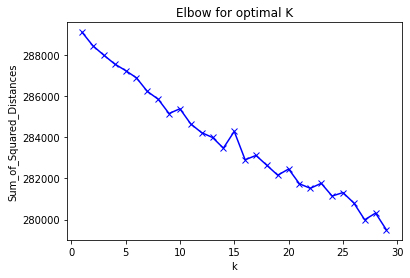

In [0]:
import matplotlib.pyplot as plt
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_Squared_Distances')
plt.title('Elbow for optimal K')
plt.show()

In [0]:
start_time = time.time()

true_k = 16
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, n_init=10)
model.fit(features)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1069.7405953407288 seconds ---


In [0]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    cluster_names = []
    for ind in order_centroids[i, :15]:
      cluster_names.append(terms[ind])
        #print(' %s' % terms[ind]),
    print (cluster_names)

Top terms per cluster:
Cluster 0:
['account', 'email', 'address', 'password', 'received', 'log', 'money', 'help', 'sent', 'bank', 'need', 'premium', 'number', 'amazon', 'contact']
Cluster 1:
['yes', 'ha', 'response', 'times', 'issue', 'email', 'thanks', 'tried', 'today', 'days', 'worked', 'work', 'time', 'working', 'said']
Cluster 2:
['going', 'hey', 'card', 'credit', 'guys', 'gift', 'time', 'app', 'new', 'use', 'pay', 'order', 'know', 'need', 'like']
Cluster 3:
['data', 'fuck', 'use', 'fucking', 'phone', 'plan', 'network', 'unlimited', 'shit', 'internet', 'wifi', 'month', 'mobile', 'want', 'need']
Cluster 4:
['train', 'cancelled', 'delayed', 'london', 'euston', 'ticket', 'late', 'time', 'service', 'paddington', 'station', 'manager', 'trains', 'staff', 'going']
Cluster 5:
['error', 'getting', 'message', 'code', 'trying', 'try', 'help', 'app', 'says', 'tried', 'saying', 'play', 'keeps', 'page', 'fix']
Cluster 6:
['dm', 'sent', 'check', 'follow', 'reply', 'kindly', 'hasent', 'send', 'res

In [0]:
model.labels_

array([ 9,  1,  3, ...,  9, 11,  2], dtype=int32)

## Running it against the Crawled Tweets Dataset

In [0]:
twitter_text = clean_tweets['text'].apply(clean_text)

In [0]:
twt_vec = TfidfVectorizer(stop_words='english')
twt_vec.fit(twitter_text)
twt_features = vec.transform(twitter_text)

In [0]:
model.predict(twt_features)

array([8, 6, 9, ..., 9, 8, 9], dtype=int32)

In [0]:
model.fit_predict(twt_features)

array([ 8,  1,  1, ...,  1, 14,  1], dtype=int32)

In [0]:
clean_tweets['predict'] = model.predict(twt_features)
clean_tweets['fit_predict'] = model.fit_predict(twt_features)

In [0]:
clean_tweets

,tweet_id,author_id,inbound,created_at,text,in_response_to_tweet_id,customers_of,CleanedText,CleanerText,predict,fit_predict
0,1249193154512916480,375541562,False,2020-04-12 04:30:31,@Jetstar_Asia Please check your DM. Thanks @Je...,1.249190e+18,JetStar Asia,Please check your DM. Thanks,"[Please, check, your, DM, ., Thanks]",8,12
1,1249189062759665667,375541562,False,2020-04-12 04:14:16,@Jetstar_Asia Pleas help me. I have also tried...,1.249186e+18,JetStar Asia,Pleas help me. I have also tried calling seve...,"[Pleas, help, me, ., I, have, also, tried, cal...",1,12
2,1249040470401060864,1024338385404682246,True,2020-04-11 18:23:48,RT @monilsj: Hi @Jetstar_Asia! I have noticed ...,NaN,JetStar Asia,RT Hi I have noticed that Air Asia and more ...,"[RT, Hi, I, have, noticed, that, Air, Asia, an...",1,12
3,1249038696214458369,286610770,True,2020-04-11 18:16:45,Hi @Jetstar_Asia! I have noticed that Air Asia...,NaN,JetStar Asia,Hi I have noticed that Air Asia and more rece...,"[Hi, I, have, noticed, that, Air, Asia, and, m...",1,12
4,1248566696798867456,1048797604019036160,True,2020-04-10 11:01:12,RT @RayMSLim: @Jetstar_Asia why do you make it...,NaN,JetStar Asia,RT why do you make it so difficult to apply ...,"[RT, why, do, you, make, it, so, difficult, to...",4,3
...,...,...,...,...,...,...,...,...,...,...,...
7638,1246335441596321793,122037642,False,2020-04-04 07:14:59,@CebuPacificAir Where is your DM? https://t.co...,1.246197e+18,Cebu Pacific Air,Where is your DM?,"[Where, is, your, DM, ?]",8,4
7639,1246334892729708545,122037642,False,2020-04-04 07:12:48,@iseemelons @CebuPacificAir No you DID NOT!,1.246201e+18,Cebu Pacific Air,No you DID NOT!,"[No, you, DID, NOT, !]",1,0
7640,1246334331590598656,1246263403930193920,False,2020-04-04 07:10:35,@CebuPacificAir How to refund my additional ba...,1.242433e+18,Cebu Pacific Air,How to refund my additional baggage that I av...,"[How, to, refund, my, additional, baggage, tha...",1,0
7641,1246333808573464576,211427232,True,2020-04-04 07:08:30,"Hi @CebuPacificAir, havent received a reply to...",NaN,Cebu Pacific Air,Hi havent received a reply to my DM since las...,"[Hi, havent, received, a, reply, to, my, DM, s...",14,4
